<a href="https://colab.research.google.com/github/SophieShin/MachineLearning/blob/main/Topic_Modelling%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EB%B0%B8%EB%A5%98%EC%97%85_%EA%B8%B0%EC%97%85%EC%9D%98_%EA%B3%B5%EC%8B%9C%EC%A0%84%ED%9B%84_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

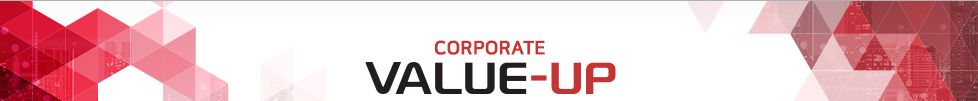

#**Topic Modelling을 이용한 밸류업 기업(KB금융) 공시전후 텍스트 분석**

*KB금융이 가장 먼저 밸류업 공시('24.5.27)하여 공시일 이후 텍스트 수집기간이 가장 길기 때문에 KB금융을 선택하였으며,

다른 밸류업 기업도 텍스트 수집 후 동일한 코드로 비교 분석 가능합니다.

                                                          




>파생상품시장본부 FICC파생제도팀 신소희





###(순서)

**1.   데이터 불러오기**

**2.   텍스트 전처리(숫자, 영어, 특수기호 등 제거)**

**3. 빈도수 확인**

**4. 워드 클라우드 만들어보기**

**5. LDA(Latent Dirichlet Allocation)를 이용한 Topic Modelling**

**6. DMR(Dirichlet Multinomial Regression)을 이용한 공시전후 Topic 비교**






>업무 확장성 : 아래 코드는 밸류업 기업의 공시 전후 텍스트 뿐만 아니라 그룹간 텍스트 비교에도 활용할 수 있습니다.

(예시)
* 관리종목/우량종목 사업보고서 텍스트 비교
*  실질심사 대상결정 공시 이후 애널리스트 리포트/기사/SNS 텍스트 비교
* 코스피200 편입 전후 애널리스트 리포트/기사 텍스트 비교
* 주식선물 존재/비존재 그룹 간 애널리스트 리포트/기사 텍스트 비교


*직접 실행하고자 하시면 아래 각 셀의 재생버튼(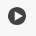 )을 누르시면 됩니다. 😊


In [ ]:
# 필요한 라이브러리 설치

!apt-get update -qq
!apt-get install fonts-nanum* -qq
!sudo fc-cache -fvㅓ
!pip install kiwipiepy tomotopy flashtext -q

!pip install pyLDAvis

!pip install konlpy

fc-cache: invalid option -- '�'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose            display status information while busy
  -V, --version            display font config version and exit
  -h, --help               display this help and exit


In [ ]:
# 필요한 라이브러리 불러오기, 나눔고딕 설치

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib.colors as clr

from collections import Counter
import regex
import re

from kiwipiepy import Kiwi
kiwi = Kiwi()

from flashtext import KeywordProcessor
kp = KeywordProcessor()

import tomotopy as tp
print(tp.isa)
import sys

avx2


## 1. 데이터 불러오기

최초 밸류업 기업인 'KB금융'의 밸류업 공시일('24.5.27) 전후 애널리스트 리포트, 기사, KB금융 보도자료를 각각 50개씩 수집

In [ ]:
# https://github.com/SophieShin/MachineLearning/blob/main/KB%EA%B8%88%EC%9C%B5.csv 에 저장한 CSV 파일 불러오기
# 공시일 이후 텍스트는 'AFTER', 이전 텍스트는 'BEFORE'로 구분

df = pd.read_csv('https://raw.githubusercontent.com/SophieShin/MachineLearning/main/KB%EA%B8%88%EC%9C%B5.csv')
df.head()

,Text,Timing
0,높은 자본비율에 따른 자사주 매입 확대 기대\n2Q24 Preview\n기대치 상회...,AFTER
1,이제 PBR 0.53배. 아직도 갈길은 멀다\n신탁 책임준공 추가 충당금 적립 등에...,AFTER
2,"KB금융 은행업종 Top Pick 유지. 경상 이익과 자본비율, 주주환원 등\n모든...",AFTER
3,2Q24 Preview: 지배주주순이익 소폭 증가 예상(전년동기대비 上低下高)\n2...,AFTER
4,"은행 최선호주 제시\n투자의견 매수, 목표주가 100,000원 제시\nKB금융에 대...",AFTER


In [ ]:
df.tail()

,Text,Timing
95,ESG 총평 : 섹터 내 선두적인 ESG 지위\n-환경 부문(E)에서 친환경 관련 ...,BEFORE
96,"비은행 실적 부진, 선제적 대손 적립으로 실적 부진\nKB 금융은 전년 4 분기 대...",BEFORE
97,AAA등급은 글로벌 은행산업 내 상위 5%에 해당하는 최상위 등급\n\n■ KB금융...,BEFORE
98,AI가 최적의 상담원을 찾아 연결하는 “KB Link 서비스”로 고객 편의성 강화\...,BEFORE
99,고객 관점의 금융상품 개발 역량 확보를 위한 ‘KB고객데이터플랫폼’ 구축\n\n■ ...,BEFORE


In [ ]:
# 공시 전후 텍스트 갯수

df['Timing'].value_counts()

Timing
AFTER     50
BEFORE    50
Name: count, dtype: int64

## 2. 텍스트 전처리

텍스트가 아래와 같이 특수문자, 영어, 숫자 등이 섞여있어 한글만 남기기 위해 텍스트 전처리 필요




In [ ]:
df.iloc[10,0]

'양종희 KB금융 회장 "고객이 피부로 느낄 수 있게 디지털 혁신" \n인쇄\n \n \n\n\n\n//img.biz.sbs.co.kr/upload/2024/01/02/GJm1704159597305-850.jpg 이미지\n[양종희 KB금융그룹 회장.]\n\nKB금융그룹은 지난 4일 KB국민은행 신관 다목적홀에서 고객 관점의 디지털 혁신 전략을 수립하기 위해 \'디지털·IT부문 전략워크숍\'을 개최했다고 오늘(5일) 밝혔습니다. \n\n이번 워크숍은 고객 중심의 디지털 혁신 전략 발굴을 위한 발표 세션과 AWS(아마존 웹서비스)와 같은 생성형AI 전문기업이 전달하는 \'생성형AI의 최신 기술동향과 활용사례\'를 담은 특강 세션으로 구성됐습니다.\n\nKB금융 전 계열사의 디지털·IT 부문 경영진 50여명은 ▲생성형AI 기술의 내재화 ▲비대면·디지털 중심의 코어뱅킹 현대화▲마이데이터 기반의 계열사 간 협업 전략 등을 주제로 심도 있는 논의를 진행했습니다.\n\n양종희 KB금융 회장은 "진정한 디지털 혁신은 고객이 차별화된 경험을 피부로 느낄 수 있을 때 이루어 지는 것"이라며 "디지털·AI는 KB금융의 미래 성장을 위한 핵심 동력이므로 고객 관점의 디지털 혁신을 통해 그룹의 경쟁력을 확보할 수 있도록 힘써달라"고 말했습니다.\n\n한편, KB금융은 금융권 최초로 KB국민은행, KB증권, KB손해보험, KB국민카드, KB라이프생명 등 지주를 포함한 9개 금융 계열사가 함께 이용할 수 있는 \'그룹 공동 생성형 AI 플랫폼\'을 구축하고 있습니다. \n\n이에 더해 지난 2022년 10월 수립한 금융권 최초의 AI윤리기준을 바탕으로 AI위험을 체계적으로 관리할 수 있는 AI거버넌스 프레임도 연내 도입 예정입니다. \nNaver에서 SBS Biz 뉴스 구독하기!'

In [ ]:
# 전처리 실시(한글만 남김)

preprocessed_text = []
for i in range(df.shape[0]):
  text = df.iloc[i,0]
  text = re.sub(r'㈜',' ', str(text))
  text = re.sub(r'ㆍ', '', str(text))
  text = re.sub(r'[0-9]+', '', str(text))
  text = re.sub(r"\n{1,}", '', str(text))
  text = re.sub(r"[a-zA-Z]{1,}", '', str(text))
  text = re.sub(r"\W", ' ', str(text))
  text = re.sub(r"①|②|③|④|⑤|⑥|⑦|⑧|⑨", '', str(text))
  text = re.sub('nan', '', str(text))
  preprocessed_text.append(text)

In [ ]:
# 전처리한 텍스트 추가

df['preprocessed_text'] = pd.Series(preprocessed_text)
df.head()

,Text,Timing,preprocessed_text
0,높은 자본비율에 따른 자사주 매입 확대 기대\n2Q24 Preview\n기대치 상회...,AFTER,높은 자본비율에 따른 자사주 매입 확대 기대 기대치 상회 예상 금융의 지배주주순...
1,이제 PBR 0.53배. 아직도 갈길은 멀다\n신탁 책임준공 추가 충당금 적립 등에...,AFTER,이제 배 아직도 갈길은 멀다신탁 책임준공 추가 충당금 적립 등에도 불구하고 분...
2,"KB금융 은행업종 Top Pick 유지. 경상 이익과 자본비율, 주주환원 등\n모든...",AFTER,금융 은행업종 유지 경상 이익과 자본비율 주주환원 등모든 측면에서 투자자에게...
3,2Q24 Preview: 지배주주순이익 소폭 증가 예상(전년동기대비 上低下高)\n2...,AFTER,지배주주순이익 소폭 증가 예상 전년동기대비 上低下高 지배주주순이익 ...
4,"은행 최선호주 제시\n투자의견 매수, 목표주가 100,000원 제시\nKB금융에 대...",AFTER,은행 최선호주 제시투자의견 매수 목표주가 원 제시금융에 대해 투자의견 매수 목...


## 3. 빈도수 확인

밸류업 공시 전후 텍스트에 포함된 단어 빈도수 확인

빈도수 확인을 위해 Raw Data 텍스트(말뭉치, Corpus)를 토큰화(Tokenization) 필요






> "주어진 텍스트(코퍼스,corpus)에서 토큰(token)이라 불리는 단위로 나누는 작업을 토큰화(tokenization)라고 합니다. 토큰의 단위가 상황에 따라 다르지만, 보통 의미있는 단위로 토큰을 정의합니다."

* 토큰(Token) : 가장 기본이 되는 단어, 일반적으로 일정한 의미가 있는 가장 작은 정보 단위

* 토크나이징(Tokenizing) : 언어를 토큰화하는 것

* 형태소 : 일정한 의미가 있는 가장 작은 단위(언어학에서 사용되는 용어)






(한국어 토큰화 예시)





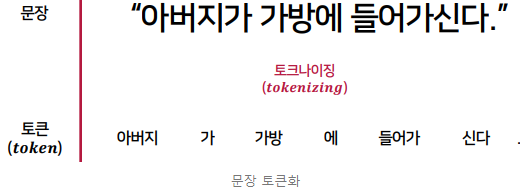

In [ ]:
# 토큰화 위해 토큰화 함수 지정

import konlpy

def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)  ## ,.?!와 문자+숫자+_(\w)와 공백(\s)만 남김  # 앞에 r을 붙여주면 deprecation warning이 안뜸 (raw string으로 declare)

    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)   # stem=True로 설정하면 동사원형으로 바꿔서 return

    words = []
    for word, pos in Okt_morphs:
        if pos == 'Noun':  # 명사만 남김
            words.append(word)

    words_str = ' '.join(words)
    return words_str


# review_df['Preprocessed_text']를 하나씩 tokenize해서 list로 저장
tokenized_list = []

for text in df['preprocessed_text']:
    tokenized_list.append(tokenize_korean_text(text))



In [ ]:
# 전처리한 텍스트(Preprocessed Text)를 토큰화 함수에 넣어 토큰화 실시

df['Tokenized_text'] = pd.Series(tokenized_list)
df.head()

,Text,Timing,preprocessed_text,Tokenized_text
0,높은 자본비율에 따른 자사주 매입 확대 기대\n2Q24 Preview\n기대치 상회...,AFTER,높은 자본비율에 따른 자사주 매입 확대 기대 기대치 상회 예상 금융의 지배주주순...,자본 비율 자 사주 매입 확대 기대 대치 상회 예상 금융 지배 순이익 조 억원 컨센...
1,이제 PBR 0.53배. 아직도 갈길은 멀다\n신탁 책임준공 추가 충당금 적립 등에...,AFTER,이제 배 아직도 갈길은 멀다신탁 책임준공 추가 충당금 적립 등에도 불구하고 분...,이제 배 신탁 책임 준공 추가 충당금 적립 등 불구 분기 대의 익 예상 금융 대한 ...
2,"KB금융 은행업종 Top Pick 유지. 경상 이익과 자본비율, 주주환원 등\n모든...",AFTER,금융 은행업종 유지 경상 이익과 자본비율 주주환원 등모든 측면에서 투자자에게...,금융 은행 업종 유지 경상 이익 자본 비율 주주 환원 등 모든 측면 투자자 가장 은...
3,2Q24 Preview: 지배주주순이익 소폭 증가 예상(전년동기대비 上低下高)\n2...,AFTER,지배주주순이익 소폭 증가 예상 전년동기대비 上低下高 지배주주순이익 ...,지배 순이익 폭 증가 예상 년 대비 지배 순이익 인 조 억원 예상 이자 이익 증가 ...
4,"은행 최선호주 제시\n투자의견 매수, 목표주가 100,000원 제시\nKB금융에 대...",AFTER,은행 최선호주 제시투자의견 매수 목표주가 원 제시금융에 대해 투자의견 매수 목...,은행 최선 호주 제시 투자 의견 매수 목표 주가 원 금융 대해 투자 의견 매수 목표...


In [ ]:
# 토큰화 전후 비교 - Raw Data가 의미를 갖는 가장 작은 단위로 쪼개진 것을 확인 가능

print('토큰화 이전\n')
df.iloc[1,2]

토큰화 이전



'이제   배  아직도 갈길은 멀다신탁 책임준공 추가 충당금 적립 등에도 불구하고 분기  조원대의 순익 예상금융에 대한 투자의견 매수를 유지하고  목표주가를  원으로 상향  목표가 상향은리딩뱅크 프리미엄을 감안한 자본비용 할인율 축소 및 분기 호실적 등을 반영했기 때문 금융 분기 추정 순익은 약  조원으로 전분기대비    증가해 컨센서스 상회 예상 신탁 책임준공 관련 추가 부담 등 약    억원의  관련 추가 충당금 적립에도 불구하고 홍콩 지수 상승에 따른  고객 보상비용  억원 환입 등이 이를 어느정도상쇄할 것으로 전망되기 때문    월부터 가계대출과 대기업대출이 늘어나면서 분기 은행원화대출금이 약      성장하고  은  하락에 그쳐 순이자이익 증가세가 지속되는데다   시중금리 하락에 따른 유가증권 관련익 증가와 증권 수입수수료 개선 등에 힘입어 비이자이익도 상당히 선방할 것으로 추정     연착륙을 위한 정책 방향과 관련한 추가충당금은 억원 미만에 그치겠지만 신탁 책임준공 관련 충당금 적립 등으로 분기 그룹대손비용은  억원 내외로 다시 증가할 것으로 예상  신한자산신탁과 부동산자산신탁의 책임준공 관리형 토지신탁 대출 실행 잔액이 년말 기준 각각  조원과  조원으로 규모가 상당히 커지면서 감독당국이 리스크 점검에 나섰고  이로 인해 대손비용이 늘어날 것으로 추정됨  그러나 경상 이익 체력이 크게 레벨업되면서 추가 충당금에도 불구하고 분기에  조원이 넘는 실적을 시현할 것으로 예상되는데다 향후 한화오션 충당금 환입가능성 등의 일회성 이익 기여 요인들도 상존하고 있어 분기 중  억원을 상회하는 관련 비용을 인식했음에도 불구하고 올해 연간 순익은  조원을 상회할 것으로 기대총주주환원율  를 가장 먼저 상회할 수 있는 은행  밸류업 대장주 지위 유지 예상시장의 관심은 동사가 월에 발표할 자사주 매입 소각 규모가 얼마일지의 여부 통상 금융은 년에 두차례 월과 월에 자사주 매입 소각을 발표해 왔음   정부의 중점 추진 사항인밸류업 분위기를 감안시 월의  억원보다는 상

In [ ]:
print('토큰화 이후')
print('->텍스트가 의미를 갖는 가장 작은 단위로 쪼개진 것을 확인 가능\n')
df.iloc[1,3]

토큰화 이후
->텍스트가 의미를 갖는 가장 작은 단위로 쪼개진 것을 확인 가능



'이제 배 신탁 책임 준공 추가 충당금 적립 등 불구 분기 대의 익 예상 금융 대한 투자 의견 매수 유지 목표 주가 원 상향 목표 상향 리딩 뱅크 프리미엄 감안 자본 비용 할인 율 축소 및 분기 호실 등 반영 때문 금융 분기 추정 익 약 조원 분기 대비 증가 컨센서스 상회 예상 신탁 책임 준공 관련 추가 부담 등 약 억원 관련 추가 충당금 적립 불구 홍콩 지수 상승 고객 보상 비용 억원 환입 등 정도 쇄 것 전망 때문 월 가계 대출 대기업 대출 분기 은행원 화대 출금 약 은 하락 이자 이익 증가 세 지속 시중금리 하락 유가 증권 관련 익 증가 증권 수입 수수료 개선 등 힘 이익 선방 것 추정 착륙 위 정책 방향 관련 추가 충당금 억원 미만 신탁 책임 준공 관련 충당금 적립 등 분기 그룹 대손 비용 억원 내외 다시 증가 것 예상 자산 신탁 부동산 자산 신탁 책임 준공 관리 토지 신탁 대출 실행 잔액 년말 기준 각각 조원 조원 규모 감독 당국 리스크 점검 이로 대손 비용 것 추정 경상 이익 체력 크게 레벨 면서 추가 충당금 불구 분기 조원 실적 현 것 예상 향후 한화 오션 충당금 환입 가능성 등 회 이익 기여 요인 상존 분기 중 억원 상회 관련 비용 인식 불구 올해 연간 익 조원 상회 것 환원 율 를 가장 먼저 상회 수 은행 밸류업 장주 지위 유지 예상 시장 관심 동사 월 발표 자 사주 매입 소각 규모 얼마 일지 여부 통상 금융 년 차례 월 월 자 사주 매입 소각 발표 정부 중점 추진 사항 밸류업 분위기 감안 시 월 억원 상당 폭 것 예상 대출 성장 률 환율 상승 등 증가 요인 등 비율 추가 하락 경우 금번 자 사주 매입 소각 규모 시장 대치 충족 가능성 다만 분기 추가 자 사주 매입 소각 가능성 올해 연간 자 사주 매입 소각 규모 최소 억원 이상 환원 율 를 상회 최초 금융 지주사 것 기대 한편 금융 배당 액 기준 분기 균등 배당 시행 중이 분기 약 백만 주의 자 사주 매입 점 감안 시 분기 원 상승 예상 연초 이후 주가 승률 행 대비 초과 상승 폭 대한 부담 

In [ ]:
# 분석에 포함하지 않을 단어들 제거

stopwords = ['국민은행', '국민', '은행', '증권', '억원', '우리', '사항', '대한', '표시', '관련',  '회사', '기업']
df['Tokenized_text'] = df['Tokenized_text'].map(lambda x:[w for w in x.split(' ') if not w in set(stopwords)])

In [ ]:
# 1음절 제거(은, 는, 이, 가, 등...)

hangul_1 = regex.compile(r'^\p{Hangul}{1}$')
df['Tokenized_text'] = df['Tokenized_text'].map(lambda x : [w for w in x if not hangul_1.match(w)])
df['Tokenized_text']

0     [자본, 비율, 사주, 매입, 확대, 기대, 대치, 상회, 예상, 금융, 지배, 순...
1     [이제, 신탁, 책임, 준공, 추가, 충당금, 적립, 불구, 분기, 대의, 예상, ...
2     [금융, 업종, 유지, 경상, 이익, 자본, 비율, 주주, 환원, 모든, 측면, 투...
3     [지배, 순이익, 증가, 예상, 대비, 지배, 순이익, 예상, 이자, 이익, 증가,...
4     [최선, 호주, 제시, 투자, 의견, 매수, 목표, 주가, 금융, 대해, 투자, 의...
                            ...                        
95    [섹터, 선두, 지위, 환경, 부문, 친환경, 제시, 통해, 상품, 투자, 대출, ...
96    [실적, 부진, 선제, 대손, 적립, 실적, 부진, 금융, 분기, 대비, 감소, 시...
97    [등급, 글로벌, 산업, 상위, 해당, 상위, 등급, 금융, 계열, 사가, 경영, ...
98    [최적, 상담, 서비스, 고객, 편의, 강화, 금융, 그룹, 회장, 양종, 금융, ...
99    [고객, 관점, 금융, 상품, 개발, 역량, 확보, 고객, 데이터, 플랫폼, 구축,...
Name: Tokenized_text, Length: 100, dtype: object

In [ ]:
# 빈도수를 세기 위해 밸류업 공시 이후 나온 텍스트를 합치기

text_after = []
for i in range(len(df[df['Timing'] == 'AFTER'])):
  text_after.extend(str(df['Tokenized_text'][i]).split(' '))

print('밸류업 공시 이후 텍스트의 총 단어수:')
len(text_after)

밸류업 공시 이후 텍스트의 총 단어수:


11054

In [ ]:
# 빈도수를 세기 위해 밸류업 공시 이전 나온 텍스트를 합치기

text_before = []
for i in range(len(df[df['Timing'] == 'AFTER']),len(df)):
  text_before.extend(str(df['Tokenized_text'][i]).split())

print('밸류업 공시 이전 텍스트의 총 단어수:')
len(text_before)

밸류업 공시 이전 텍스트의 총 단어수:


14636

In [ ]:
# 빈도수 세는 모듈 불러오기

from collections import Counter

text_after_counter = Counter(text_after)
text_after_counter.most_common

text_before_counter = Counter(text_before)
text_before_counter.most_common

<bound method Counter.most_common of Counter({"'금융',": 554, "'자본',": 234, "'그룹',": 178, "'분기',": 156, "'이익',": 155, "'회장',": 131, "'영업',": 129, "'대비',": 113, "'고객',": 111, "'지주',": 107, "'증가',": 97, "'부문',": 90, "'사업',": 90, "'관리',": 86, "'사외이사',": 83, "'수준',": 80, "'비용',": 75, "'실적',": 74, "'비율',": 72, "'개선',": 70, "'순이익',": 69, "'조억원',": 69, "'시장',": 67, "'통해',": 66, "'유지',": 65, "'올해',": 64, "'부사',": 64, "'확대',": 64, "'환원',": 63, "'충당금',": 61, "'투자',": 59, "'대출',": 59, "'경영',": 58, "'성장',": 58, "'수익',": 57, "'예상',": 55, "'목표',": 54, "'부코',": 54, "'평가',": 53, "'상승',": 53, "'자산',": 53, "'기간',": 53, "'감소',": 53, "'기준',": 52, "'규모',": 52, "'대표',": 50, "'보험',": 50, "'기록',": 49, "'크게',": 48, "'전략',": 48, "'이자',": 47, "'조직',": 47, "'본부',": 47, "'기관',": 46, "'지난해',": 45, "'주주',": 45, "'주가',": 44, "'가장',": 44, "'전망',": 44, "'글로벌',": 44, "'당국',": 43, "'추가',": 43, "'핵심',": 43, "'기존',": 43, "'인도네시아',": 42, "'부행',": 41, "'위해',": 41, "'인사',": 41, "'안정',": 39, "'열사',": 38, "'상품',": 38, "'최근',": 37, "'펀드',": 37, "'상생',": 37, "'조원',": 36, "'국내',": 35, "'계열',": 35, "'선임',": 35, "'이번',": 34, "'디지털',": 34, "'대손',": 33, "'전체',": 32, "'적립',": 32, "'이사회',": 32, "'사주',": 32, "'경우',": 32, "'캐피탈',": 32, "'각각',": 31, "'배당',": 31, "'협업',": 31, "'손해',": 30, "'코로나',": 30, "'임기',": 30, "'잉여',": 30, "'활용',": 29, "'중심',": 29, "'소각',": 29, "'후보',": 29, "'발행',": 29, "'상황',": 28, "'센터',": 28, "'총괄',": 28, "'하나',": 27, "'추진',": 27, "'자회사',": 27, "'때문',": 26, "'발표',": 26, "'가운데',": 26, "'만큼',": 26, "'계획',": 26, "'효율',": 25, "'금리',": 25, "'성과',": 25, "'리스크',": 25, "'구축',": 25, "'부서',": 25, "'대규모',": 24, "'이상',": 24, "'반영',": 24, "'운영',": 24, "'경기',": 24, "'결과',": 24, "'수수료',": 24, "'운용',": 24, "'신설',": 24, "'의견',": 24, "'추정',": 24, "'영향',": 23, "'다만',": 23, "'부동산',": 23, "'손익',": 23, "'관계자',": 23, "'대상',": 23, "'서비스',": 23, "'자리',": 23, "'현지',": 23, "'양종',": 22, "'다른',": 22, "'포함',": 22, "'정책',": 22, "'적극',": 22, "'이슈',": 22, "'자산운용',": 22, "'시작',": 22, "'사회',": 22, "'감안',": 22, "'상회',": 22, "'재직',": 21, "'제외',": 21, "'현재',": 21, "'카드',": 21, "'진행',": 21, "'손보',": 21, "'지속',": 21, "'신임',": 21, "'체계',": 21, "'월말',": 21, "'보통주',": 21, "'취임',": 20, "'손실',": 20, "'지표',": 20, "'지난',": 20, "'요인',": 20, "'집계',": 20, "['금융',": 20, "'지원',": 20, "'효과',": 20, "'가치',": 20, "'매입',": 20, "'기반',": 20, "'집중',": 20, "'시너지',": 20, "'진출',": 20, "'여성',": 20, "'승진',": 20, "'본부장',": 20, "'리딩',": 19, "'강화',": 19, "'동기',": 19, "'발생',": 19, "'한국',": 19, "'데이터',": 19, "'바탕',": 19, "'지역',": 19, "'채널',": 19, "'이후',": 18, "'향후',": 18, "'대응',": 18, "'양호',": 18, "'전무',": 18, "'부담',": 18, "'업무',": 18, "'보수',": 17, "'자기',": 17, "'담당',": 17, "'임원',": 17, "'정도',": 17, "'부진',": 17, "'차원',": 17, "'지배구조',": 17, "'판단',": 17, "'강조',": 17, "'직원',": 17, "'법인',": 17, "'추천',": 17, "'기본',": 16, "'하락',": 16, "'차지',": 16, "'조달',": 16, "'전반',": 16, "'검토',": 16, "'역할',": 16, "'불확실',": 16, "'지점',": 16, "'상반기',": 16, "'둔화',": 16, "'컨센서스',": 16, "'주요',": 15, "'부회장',": 15, "'포인트',": 15, "'설명',": 15, "'선제',": 15, "'업계',": 15, "'제공',": 15, "'확보',": 15, "'비중',": 15, "'모두',": 15, "'해외',": 15, "'역시',": 15, "'개편',": 15, "'미래',": 15, "'적정',": 15, "'단기간',": 15, "'오버',": 15, "'신종',": 15, "'종자',": 15, "'재무',": 14, "'최대',": 14, "'포트폴리오',": 14, "'최고',": 14, "'민간',": 14, "'신규',": 14, "'항목',": 14, "'가지',": 14, "'종합',": 14, "'정성',": 14, "'연결',": 14, "'작년',": 14, "'경상',": 14, "'경쟁',": 13, "'역량',": 13, "'가량',": 13, "'부실',": 13, "'보유',": 13, "'연간',": 13, "'직접',": 13, "'결정',": 13, "'단계',": 13, "'해당',": 13, "'경험',": 13, "'선정',": 13, "'다소',": 13, "'통한',": 13, "'평균',": 13, "'영진',": 13, "'실제',": 13, "'과정',": 13, "'전환',": 13, "'유동성',": 13, "'체제',": 13, "'가계',": 13, "'정치',": 13, "'판매',": 12, "'라며',": 12, "'우량',": 12, "'예정',": 12, "'인물',": 12, "'장기',": 12, "'출신',": 12, "'동시',": 12, "'제시',": 12, "'지배',": 12, "'플랫폼',": 12, "'누적',": 12, "'기여',": 11, "'하향',": 11, "'방침',": 11, "'제도',": 11, "'채권',": 11, "'건전성',": 11, "'방향',": 11, "'전입',": 11, "'작업',": 11, "'내부',": 11, "'위원회',": 11, "'모범',": 11, "'시스템',": 11, "'자본시장',": 11, "'흑자',": 11, "'퍼스트',":

In [ ]:
# 시각화 모듈 불러오기, 한글 깨짐 방지하기

import matplotlib
matplotlib.matplotlib_fname()

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# Rebuild the font cache - this is the correct way to refresh fonts
fm.fontManager.addfont(path)

mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


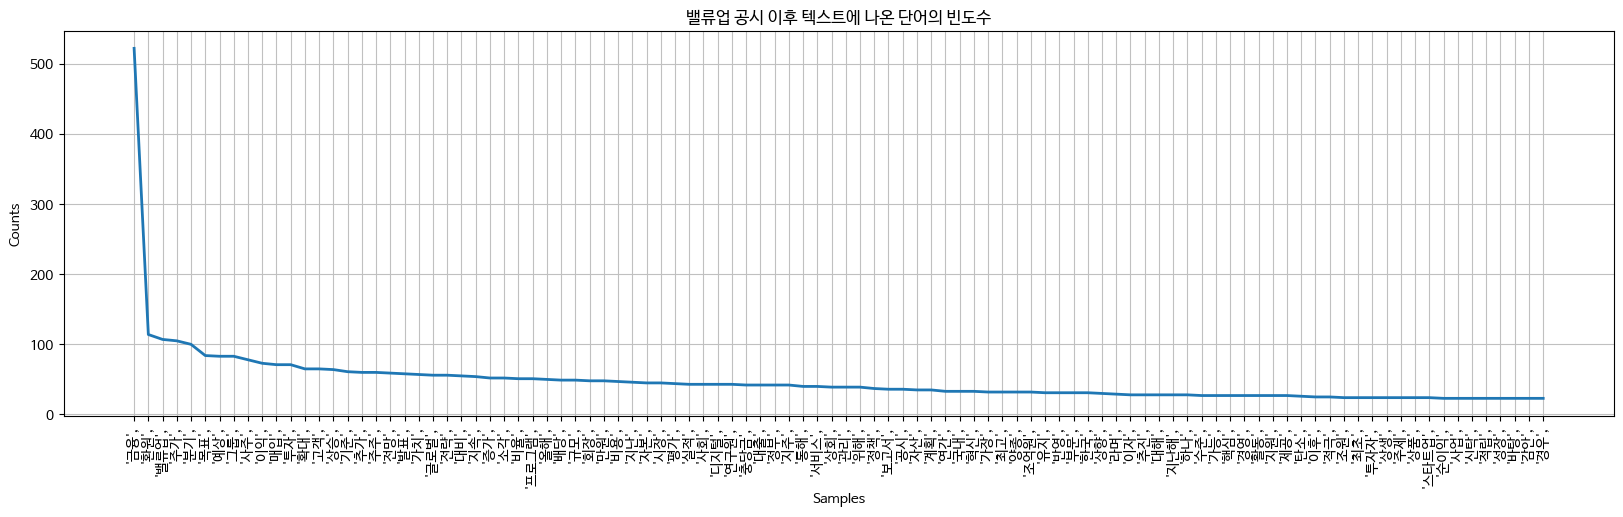

In [ ]:
# 밸류업 공시 이후 텍스트에 나온 단어의 빈도수

from nltk import Text

text = Text(text_after)
plt.figure(figsize=(20,5))
plt.title('밸류업 공시 이후 텍스트에 나온 단어의 빈도수')
text.plot(100)
plt.show()

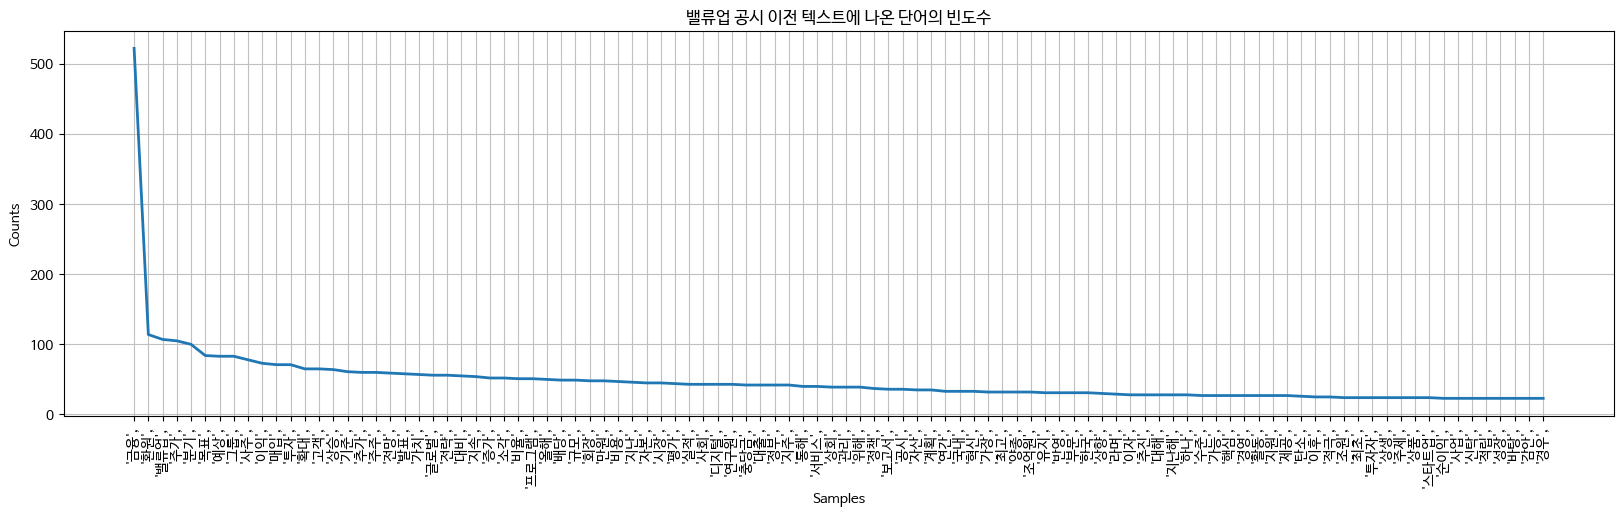

In [ ]:
# 밸류업 공시 이전 텍스트에 나온 단어의 빈도수

plt.figure(figsize=(20,5))
plt.title('밸류업 공시 이전 텍스트에 나온 단어의 빈도수')
text.plot(100)
plt.show()

*참고

지프의 법칙(Zipf's law) : 글에서 단어들이 나오는 빈도가 높은 순서대로 나열해 순위를 매기면, 그 빈도가 해당 단어의 순위에 반비례함

-> 위 그래프에서 볼 수 있듯이 밸류업 공시 전후 텍스트의 단어빈도수도 지프의 법칙을 따름

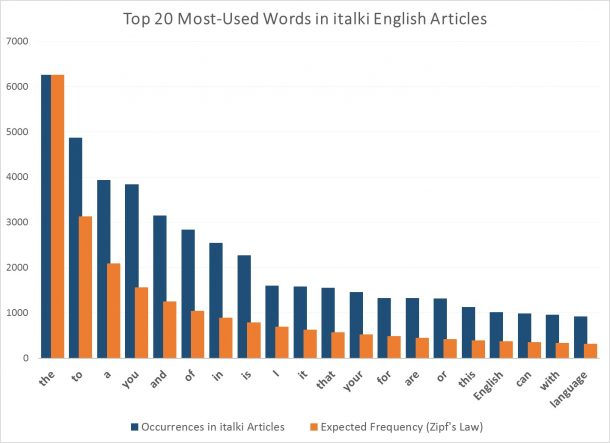

In [ ]:
# 최빈 단어 중 분석에 필요없는 단어를 불용어에 추가

df['Tokenized_text'] = pd.Series(tokenized_list)
stopwords = ['국민은행', '국민', '은행', '증권', '억원', '그룹', '우리', '사항', '대한', '표시', '관련',  '회사', '기업', '금융', '자본', '분기', '이익','대비']
df['Tokenized_text'] = df['Tokenized_text'].map(lambda x:[w for w in x.split(' ') if not w in set(stopwords)])
hangul_1 = regex.compile(r'^\p{Hangul}{1}$')
df['Tokenized_text'] = df['Tokenized_text'].map(lambda x : [w for w in x if not hangul_1.match(w)])

text_after = []
for i in range(len(df[df['Timing'] == 'AFTER'])):
  text_after.extend(str(df['Tokenized_text'][i]).split(' '))

text_before = []
for i in range(len(df[df['Timing'] == 'AFTER']),len(df)):
  text_before.extend(str(df['Tokenized_text'][i]).split())


text_after_counter = Counter(text_after)

text_before_counter = Counter(text_before)


## 4. 워드클라우드 만들어보기

밸류업 공시 전후 빈번히 나온 키워드를 워드클라우드로 시각화해보기

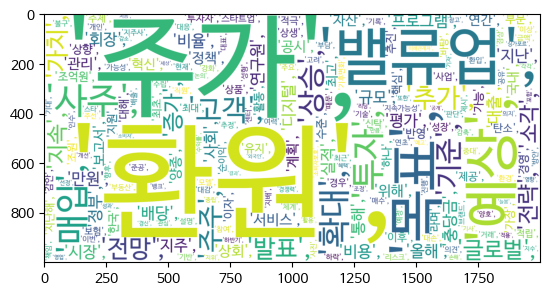

In [ ]:
# 밸류업 공시 이후 텍스트의 워드 클라우드
# 밸류업, 주주환원 등의 키워드 확인 가능

from wordcloud import WordCloud
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               background_color = 'white',
               width=1000, height=500, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(text_after_counter)
plt.figure()
plt.imshow(gen)

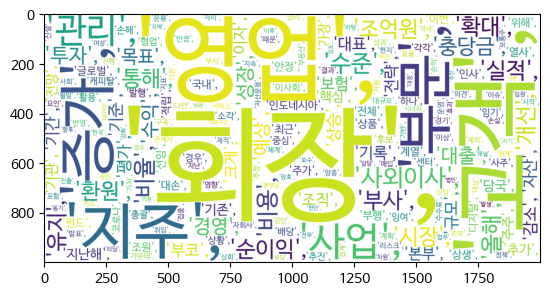

In [ ]:
# 밸류업 공시 이전 텍스트의 워드 클라우드
# '23년 회장 선임, 사업 관련 키워드 확인 가능

wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               background_color = 'white',
               width=1000, height=500, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(text_before_counter)
plt.figure()
plt.imshow(gen)

## 5. LDA(Latent Dirichlet Allocation)를 이용한 Topic Modelling





> 토픽 모델링이란 텍스트 기반의 문서 데이터에서 핵심 주제(Topic)를 찾는 데이터 분석 방법론입니다. 특히, 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)은 토픽 모델링의 가장 대표적인 알고리즘입니다. 구체적으로, LDA 토픽 모델링은 확률 기반의 모델링 기법을 통해 방대한 양의 문서 데이터를 분석함으로써 문서 내에 어떤 토픽이, 어떤 비율로 구성되어 있는지 분석합니다. 또한, 토픽별로 어떤 키워드가 구성되었는지 정보를 제공하기 때문에, 키워드 조합을 통해 인사이트를 도출하는 데 효과적인 장점이 있습니다.

*자세한 내용은 아래 링크를 참고해주세요!

https://heytech.tistory.com/328

###(1) 밸류업 공시 이후 텍스트로 Topic Modelling





In [ ]:
# 필요한 라이브러리 불러오기

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# LDA 학습

def listtostring(str_list):
    result = ""
    for s in str_list:
        if s is not None:
            result += s + " "
    return result

tokenized_list_all = []
for i in range(100):
  tokenized_list_all.append(listtostring(df['Tokenized_text'][i]))


tokenized_list_after = tokenized_list_all[0:50]

count_vectorizer_after = CountVectorizer(max_features = 50)

feat_vect_after = count_vectorizer_after.fit_transform(tokenized_list_after)


lda_after = LatentDirichletAllocation(n_components=3)  # n_components : 토픽 수(하이퍼파라미터로 분석자가 지정 가능)
lda_after.fit(feat_vect_after)


def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]

        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)

feature_names_after = count_vectorizer_after.get_feature_names_out()



In [ ]:
# Topic별 가장 연관도가 높은 keyword를 15개 추출

display_topics(lda_after, feature_names_after, 15)

Topic # 0
고객 글로벌 전략 디지털 사회 서비스 보고서 통해 위해 확대 기준 관리 가치 회장 지속
Topic # 1
밸류업 주가 만원 환원 정부 프로그램 주주 상승 지주 계획 지난 가치 배당 공시 정책
Topic # 2
예상 환원 추가 사주 매입 주가 전망 목표 비용 증가 실적 소각 충당금 상회 비율


(결과해석) LDA 토픽 모델링은 토픽별로 어떤 단어들이 구성되어 있는지 알려주지만, 해당 토픽의 제목은 알려주지 않습니다. 모델이 제시한 단어를 통해 주제를 다음과 같이 유추할 수 있습니다.

* 토픽 #0 : 최근 KB금융이 시도하는 '생성형 AI시대 대응과 고객 관점의 디지털 전략 수립' 관련 내용
* 토픽 #1 : 밸류업 공시 이후 애널리스트 리포트에서 목표주가를 상향 조정하는 내용
* 토픽 #2 : 밸류업, 주주환원 관련 내용

공시 이후의 텍스트에 내재된 토픽으로는 밸류업 관련 사항이 많으며, 최근 KB금융의 현안 관련 내용도 포함되어 있는 것을 알 수 있습니다.

 (주제의 갯수는 분석자가 지정할 수 있는 하이퍼파리미터인데, 5개로 지정하였을 때 중복되는 주제가 나와 3개로 조정하였습니다.)

###(1) 밸류업 공시 이전 텍스트로 Topic Modelling


In [ ]:
# LDA 학습

tokenized_list_before = tokenized_list_all[50:100]

count_vectorizer_before = CountVectorizer(max_features = 50)

feat_vect_before = count_vectorizer_before.fit_transform(tokenized_list_before)

lda_before = LatentDirichletAllocation(n_components=5)
lda_before.fit(feat_vect_before)

feature_names = count_vectorizer_before.get_feature_names_out() # Use get_feature_names_out()
display_topics(lda_before, feature_names, 15)

Topic # 0
부사 부코 사업 부문 지주 전략 통해 고객 투자 목표 보험 시장 확대 자산 영업
Topic # 1
사외이사 지주 기간 회장 평가 기준 지난해 통해 경영 비율 올해 관리 유지 이자 기록
Topic # 2
회장 영업 고객 지주 경영 기관 대표 본부 조직 부문 사업 올해 평가 보험 전략
Topic # 3
증가 비용 충당금 실적 대출 감소 예상 상승 개선 이자 전망 수준 환원 목표 유지
Topic # 4
조억원 비율 시장 수준 관리 수익 기간 순이익 유지 자산 환원 증가 크게 기준 성장


(결과해석)

* 토픽 #0 : KB금융이 인수한 인도네시아 부코핀 은행 관련 내용
* 토픽 #1 : 사외이사 선임 관련 내용
* 토픽 #2 : 양종회 회장 선임 관련 내용
* 토픽 #3 : 대손충당금 확대에도 불구하고 실적 개선된 내용
* 토픽 #4 : 주주환원 정책 및 견조한 실적 관련 내용

공시 이전의 텍스트에서는 밸류업 관련 키워드가 상대적으로 매우 적어, 공시 전후를 비교하였을 때 밸류업 공시 이후 KB금융 관련 텍스트에 밸류업 관련 키워드가 크게 증가한 것을 알 수 있습니다.

## 6.DMR(Dirichlet Multinomial Regression)을 이용한 공시전후 Topic 비교



>  DMR은 LDA기법을 확장한 분석기법으로 텍스트의 메타데이터(우리의 경우, 시점(공시 전/후))에 따라 텍스트에 내재된 주제의 비율이 어떻게 다른지 확인할 수 있는 모델입니다.

*자세한 내용은 아래 링크를 참고해주세요!

https://bab2min.tistory.com/575

In [ ]:
# 학습 전 토큰화 진행
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0]
    return [word + ('다' if tag.startswith('V') else '')
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S')]

# 토크나이징 함수 선언 (품사 포함)
def tokenize_tag(sent):
    res, score = kiwi.analyze(sent)[0]
    return [word + ('다' if tag.startswith('V') else '') +'/'+tag
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S')]


# token이라는 컬럼에 토크나이징 결과를 넣기
df['token'] = df['preprocessed_text'].progress_map(lambda x:tokenize(x))

df['token'] = df['token'].map(lambda x:[w for w in x if not w in set(stopwords)])
hangul_1 = regex.compile(r'^\p{Hangul}{1}$')
df['token'] = df['token'].map(lambda x:[w for w in x if not hangul_1.match(w)])

DMR = tp.DMRModel(k=10,min_df=1,tw=tp.TermWeight.PMI,rm_top=3, seed=5)

token_politics_dict = df[['token','Timing']].to_dict('index')

for k in tqdm(token_politics_dict.keys()):
    DMR.add_doc(token_politics_dict[k]['token'],token_politics_dict[k]['Timing'])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# DMR 학습(한번에 20회씩 총 500회 학습)

DMR.train(0)

print('Num docs:', len(DMR.docs), ', Vocab size:', DMR.num_vocabs, ', Num words:', DMR.num_words)
print('Removed top words:', DMR.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    DMR.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, DMR.ll_per_word))

<ipython-input-37-1c2d32c5b5d7>:3: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DMR.train(0)
Training...
<ipython-input-37-1c2d32c5b5d7>:9: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DMR.train(20)


Num docs: 100 , Vocab size: 3287 , Num words: 27316
Removed top words: ['이다', '있다', '주주']
Iteration: 0	Log-likelihood: -7.4998334753572555
Iteration: 20	Log-likelihood: -7.330827693062673
Iteration: 40	Log-likelihood: -7.234415026831177
Iteration: 60	Log-likelihood: -7.178290627249621
Iteration: 80	Log-likelihood: -7.134432607092188
Iteration: 100	Log-likelihood: -7.096044542784876
Iteration: 120	Log-likelihood: -7.073107664928642
Iteration: 140	Log-likelihood: -7.05449335695915
Iteration: 160	Log-likelihood: -7.040141883008399
Iteration: 180	Log-likelihood: -7.027246187712436
Iteration: 200	Log-likelihood: -7.024974599127219
Iteration: 220	Log-likelihood: -7.009454080840698
Iteration: 240	Log-likelihood: -6.993062160685143
Iteration: 260	Log-likelihood: -6.985484073775509
Iteration: 280	Log-likelihood: -6.97274794682907
Iteration: 300	Log-likelihood: -6.973532258566148
Iteration: 320	Log-likelihood: -6.973655730001185
Iteration: 340	Log-likelihood: -6.95199411666649
Iteration: 360	Log

AFTER [0.05390367 0.0558336  0.08970938 0.05643623 0.07504544 0.25689965
 0.12739076 0.06013301 0.18081506 0.04383321] 

BEFORE [0.07415067 0.09340973 0.08623417 0.08570021 0.19136448 0.14904726
 0.16482295 0.07467312 0.03630727 0.04429021] 



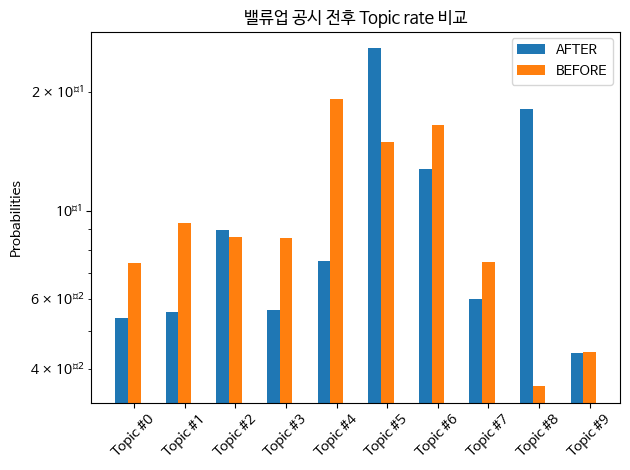

Topic #0	글로벌, 직원, 브랜드, 모델, 네트워크, 대상, 평가, 전략, 나가다, 돌봄
Topic #1	고객, 디지털, 본부, 조직, 부행장, 서비스, 센터, 계열사, 사업, 부서
Topic #2	지속, 경영, 사회, 가능, 인도네시아, 보고서, 환경, 탄소, 다양, 상품
Topic #3	회장, 상생, 주선, 인수, 신임, 내다, 경영, 리딩, 인물, 지주
Topic #4	이사, 사외, 부사장, 기간, 자본력, 지주, 선임, 여성, 후보, 신종
Topic #5	자사, 목표, 매입, 소각, 환원, 추가, 주가, 대하다, 발표, 반영
Topic #6	예상, 비용, 실적, 증가, 전년, 대출, 이자, 동기, 추정, 감소
Topic #7	대표, 기관, 영업, 임기, 자리, 평균, 내정자, 공탁금, 신한은행, 부문
Topic #8	밸류업, 정부, 제고, 프로그램, 최대, 가치, 공시, 계획, 투자, 기사
Topic #9	부코핀, 펀드, 벤처, 스타트업, 현지, 운용, 진출, 싱가포르, 민간, 사업


In [ ]:
# 공시 전/후 내재된 토픽의 비율교
probs = np.exp(DMR.lambdas - DMR.lambdas.max(axis=0))
probs /= probs.sum(axis=0)

for f, metadata_name in enumerate(DMR.metadata_dict):
    print(metadata_name, probs[:, f], '\n')

x = np.arange(DMR.k)
width = 1 / (DMR.f + 2)

fig, ax = plt.subplots()
for f, metadata_name in enumerate(DMR.metadata_dict):
    ax.bar(x + width * (f - DMR.f / 2), probs[:, f], width, label=DMR.metadata_dict[f])

ax.set_ylabel('Probabilities')
ax.set_yscale('log')
ax.set_title('밸류업 공시 전후 Topic rate 비교')
ax.set_xticks(x)
ax.set_xticklabels(['Topic #{}'.format(k) for k in range(DMR.k)],rotation=45) # x축 라벨 45도로 회전
ax.legend()

fig.tight_layout()
plt.show()


for i in range(DMR.k):
    res = DMR.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

(결과분석)

DMR 모델을 통해 공시전후 텍스트(전체)에서 주제 10가지를 위와 같이 추출하였습니다.

이 중에서 공시 전 비율이 큰 주제는 #0, #1, #4, #7, 공시 후 비율이 큰 주제는 #5, #8입니다.

* #0, #1 토픽은 KB금융이 추진하는 사업/전략(브랜드 이미지 제고, 돌봄사업, 생성형AI, 디지털 전환)과 관련한 사항임을 알 수 있고, #4, #7 토픽은 작년도 회장 및 사외이사 선임과 관련한 사항임을 알 수 있습니다.

* 한편, #5, #8 토픽은 밸류업 키워드입니다. 특히, '밸류업' 단어가 포함된 #8 토픽은 공시 전후 비율 차이가 명확하여, KB금융 관련 텍스트에서 밸류업 공시의 효과가 존재함을 알 수 있습니다.

앞서 분석한 LDA로는 방대한 텍스트에 내재된 주제를 추출하는데 효과적이라고 한다면, DMR으로는 메타데이터(시점: 공시전후)에 따른 토픽 비교를 하는데 효과적이라 목적에 따라 적절한 모델을 사용하면 됩니다.



---



### 분석을 희망하는 텍스트를 수집하여 토픽모델링을 시도해보셔요! 😊

*시도하시다가 코드 실행에 오류가 있는 경우에 문의주세요! (신소희 차장 내선번호 : 2695)



---



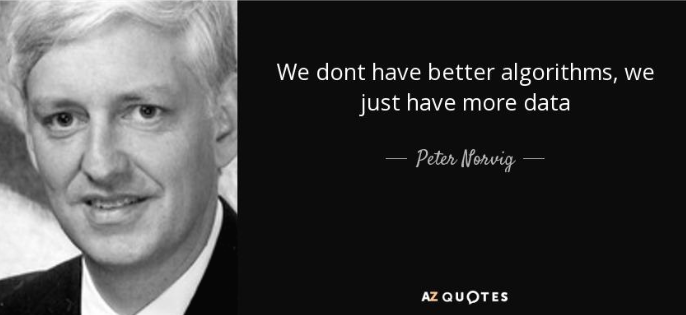

한국거래소는 금융관련 방대한 데이터를 보유한 우리나라 최대/최고의 Data Lake 입니다.

여러 인사이트를 도출할 수 있는 Raw Data를 보물처럼 소중하고 감사하게 생각하며 업무에 활용하겠습니다. 🥰